# NDM: Modelling tau evolution with NDM
This notebook loads useful data and saves it as pickle files.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

from cortography.utils import atlas_utils
from numpy import linalg as LA
from scipy.io import loadmat
from scipy.linalg import expm
from nilearn import plotting

from copy import deepcopy

import warnings
warnings.filterwarnings('ignore')

## 1. Load connectivity matrix and region names

In [2]:
# Use cortography to identify region names and connectivity
DK = atlas_utils.load_atlas('DK')
region_names = DK.index
connectivity = atlas_utils.load_connectivity(atlas='DK', portion='LRLR')
L = atlas_utils.load_laplacian(n=5)
cortical_regions = DK[DK['Cortex']=='cortical']['Other Name'].values

diagnosis = pd.read_csv('../data/diagnosis.csv').set_index('Random IDs')
tau = pd.read_csv('../data/Tau.csv').set_index('Randomized ID')
atrophy = pd.read_csv('../data/atrophy.csv').set_index('Randomized ID')

# cortical areas (number of vertices)
area = pd.read_csv('../data/area.csv').set_index('Randomized ID')
#sanitize column names
area.columns = area.columns.str.replace(' ', '')
mean_cortical_areas = area[cortical_regions].mean()

# From previous calculation:
NDM_predicted_regions = ['rh_superiortemporal',
                         'lh_superiortemporal',
                         'rh_lateraloccipital',
                         'lh_lateraloccipital', 
                         'lh_precuneus',
                         'lh_superiorfrontal', 
                         'rh_precuneus', 
                         'rh_superiorfrontal']

#### Remove regions known for undesired binding

In [3]:
print("Indices to be removed:")
print("R Cerebellum",np.argwhere(connectivity.columns=='Right-Cerebellum-Cortex'))
print("L Cerebellum",np.argwhere(connectivity.columns=='Left-Cerebellum-Cortex'))
# Remove choroid-plexus from tau data and Cerebellum from tau and connectivity
tau = tau.drop(['Right-choroid-plexus', 'Left-choroid-plexus'], axis=1)

Indices to be removed:
R Cerebellum [[77]]
L Cerebellum [[68]]


In [4]:
with open('../data/pickle_data/tau.pkl', 'wb') as handle:
    pickle.dump(tau, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('../data/pickle_data/diagnosis.pkl', 'wb') as handle:
    pickle.dump(diagnosis, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('../data/pickle_data/atrophy.pkl', 'wb') as handle:
    pickle.dump(atrophy, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('../data/pickle_data/mean_cortical_area.pkl', 'wb') as handle:
    pickle.dump(mean_cortical_areas, handle, protocol=pickle.HIGHEST_PROTOCOL)

## 2. Make average tau datasets, per diagnosis, for each visit

### 2.1. Get IDs for all patients, by diagnosis

In [5]:
idx_CN = diagnosis[diagnosis['Clinical Diagnosis'] == 'CN'].index
idx_MCI = diagnosis[diagnosis['Clinical Diagnosis'] == 'MCI'].index
idx_AD = diagnosis[diagnosis['Clinical Diagnosis'] == 'AD'].index

### 2.2 Get patients by visit

In [6]:
tau_visit_1 = tau[tau['Visit']==1]
tau_visit_2 = tau[tau['Visit']==2]
tau_visit_3 = tau[tau['Visit']==3]

atrophy_visit_1 = atrophy[atrophy['Visit']==1]
atrophy_visit_2 = atrophy[atrophy['Visit']==2]
atrophy_visit_3 = atrophy[atrophy['Visit']==3]

### 2.3 Get patients by visit AND by diagnosis

In [7]:
set(tau.index).intersection(set(idx_AD))

{32753,
 59968,
 93322,
 93347,
 94697,
 123198,
 125928,
 128400,
 138772,
 160855,
 182861,
 265436,
 302547,
 342952,
 380137,
 381301,
 415597,
 470889,
 563208,
 572507,
 599264,
 638383,
 682518,
 739008,
 757241,
 767431,
 768296,
 771468,
 824747,
 853988,
 861853,
 869853,
 894821,
 924322,
 944417}

In [8]:
# get intersection of group indices
idx_tau_AD  = set(tau.index).intersection(set(idx_AD))
idx_tau_MCI = set(tau.index).intersection(set(idx_MCI))
idx_tau_CN  = set(tau.index).intersection(set(idx_CN))


tau_AD_patients = tau.loc[idx_tau_AD]
tau_AD_visit_1 = tau_AD_patients[tau_AD_patients['Visit'] == 1]
tau_AD_visit_2 = tau_AD_patients[tau_AD_patients['Visit'] == 2]
tau_AD_visit_3 = tau_AD_patients[tau_AD_patients['Visit'] == 3]

tau_MCI_patients = tau.loc[idx_tau_MCI]
tau_MCI_visit_1 = tau_MCI_patients[tau_MCI_patients['Visit'] == 1]
tau_MCI_visit_2 = tau_MCI_patients[tau_MCI_patients['Visit'] == 2]
tau_MCI_visit_3 = tau_MCI_patients[tau_MCI_patients['Visit'] == 3]

tau_CN_patients = tau.loc[idx_tau_CN]
tau_CN_visit_1 = tau_CN_patients[tau_CN_patients['Visit'] == 1]
tau_CN_visit_2 = tau_CN_patients[tau_CN_patients['Visit'] == 2]
tau_CN_visit_3 = tau_CN_patients[tau_CN_patients['Visit'] == 3]

In [9]:
# Do the same for atrophy values
# get intersection of group indices
idx_atrophy_AD  = set(atrophy.index).intersection(set(idx_AD))
idx_atrophy_MCI = set(atrophy.index).intersection(set(idx_MCI))
idx_atrophy_CN  = set(atrophy.index).intersection(set(idx_CN))

atrophy_AD_patients = atrophy.loc[idx_atrophy_AD]
atrophy_AD_visit_1 = atrophy_AD_patients[atrophy_AD_patients['Visit'] == 1]
atrophy_AD_visit_2 = atrophy_AD_patients[atrophy_AD_patients['Visit'] == 2]
atrophy_AD_visit_3 = atrophy_AD_patients[atrophy_AD_patients['Visit'] == 3]

atrophy_MCI_patients = atrophy.loc[idx_atrophy_MCI]
atrophy_MCI_visit_1 = atrophy_MCI_patients[atrophy_MCI_patients['Visit'] == 1]
atrophy_MCI_visit_2 = atrophy_MCI_patients[atrophy_MCI_patients['Visit'] == 2]
atrophy_MCI_visit_3 = atrophy_MCI_patients[atrophy_MCI_patients['Visit'] == 3]

atrophy_CN_patients = atrophy.loc[idx_atrophy_CN]
atrophy_CN_visit_1 = atrophy_CN_patients[atrophy_CN_patients['Visit'] == 1]
atrophy_CN_visit_2 = atrophy_CN_patients[atrophy_CN_patients['Visit'] == 2]
atrophy_CN_visit_3 = atrophy_CN_patients[atrophy_CN_patients['Visit'] == 3]

In [11]:
len(tau_AD_patients)

97

### 2.4 Create longitudinal dataset
- Use only patients that came back after 18 mo

In [12]:
def index_intersection(df1, df2):
    index_set_1 = set(df1.index)
    index_set_2 = set(df2.index)
    intersection = index_set_1.intersection(index_set_2)
    return(intersection)

In [13]:
AD_longitudinal = {'tau':{'visit_1':tau_AD_visit_1.loc[index_intersection(tau_AD_visit_1, tau_AD_visit_3)].drop('Visit',axis=1),
                          'visit_2':tau_AD_visit_2.loc[index_intersection(tau_AD_visit_2, tau_AD_visit_3)].drop('Visit',axis=1),
                          'visit_3':tau_AD_visit_3.loc[index_intersection(tau_AD_visit_3, tau_AD_visit_3)].drop('Visit',axis=1)},
                  'atrophy':{'visit_1':atrophy_AD_visit_1.loc[index_intersection(atrophy_AD_visit_1, atrophy_AD_visit_3)].drop('Visit',axis=1),
                             'visit_2':atrophy_AD_visit_2.loc[index_intersection(atrophy_AD_visit_2, atrophy_AD_visit_3)].drop('Visit',axis=1),
                             'visit_3':atrophy_AD_visit_3.loc[index_intersection(atrophy_AD_visit_3, atrophy_AD_visit_3)].drop('Visit',axis=1)}}

MCI_longitudinal = {'tau':{'visit_1':tau_MCI_visit_1.loc[index_intersection(tau_MCI_visit_1, tau_MCI_visit_3)].drop('Visit',axis=1),
                           'visit_2':tau_MCI_visit_2.loc[index_intersection(tau_MCI_visit_2, tau_MCI_visit_3)].drop('Visit',axis=1),
                           'visit_3':tau_MCI_visit_3.loc[index_intersection(tau_MCI_visit_3, tau_MCI_visit_3)].drop('Visit',axis=1)},
                  'atrophy':{'visit_1':atrophy_MCI_visit_1.loc[index_intersection(atrophy_MCI_visit_1, atrophy_MCI_visit_3)].drop('Visit',axis=1),
                             'visit_2':atrophy_MCI_visit_2.loc[index_intersection(atrophy_MCI_visit_2, atrophy_MCI_visit_3)].drop('Visit',axis=1),
                             'visit_3':atrophy_MCI_visit_3.loc[index_intersection(atrophy_MCI_visit_3, atrophy_MCI_visit_3)].drop('Visit',axis=1)}}

CN_longitudinal = {'tau':{'visit_1':tau_CN_visit_1.loc[index_intersection(tau_CN_visit_1, tau_CN_visit_3)].drop('Visit',axis=1),
                          'visit_2':tau_CN_visit_2.loc[index_intersection(tau_CN_visit_2, tau_CN_visit_3)].drop('Visit',axis=1),
                          'visit_3':tau_CN_visit_3.loc[index_intersection(tau_CN_visit_3, tau_CN_visit_3)].drop('Visit',axis=1)},
                  'atrophy':{'visit_1':atrophy_CN_visit_1.loc[index_intersection(atrophy_CN_visit_1, atrophy_CN_visit_3)].drop('Visit',axis=1),
                             'visit_2':atrophy_CN_visit_2.loc[index_intersection(atrophy_CN_visit_2, atrophy_CN_visit_3)].drop('Visit',axis=1),
                             'visit_3':atrophy_CN_visit_3.loc[index_intersection(atrophy_CN_visit_3, atrophy_CN_visit_3)].drop('Visit',axis=1)}}

In [27]:
for i in MCI_longitudinal['tau']['visit_3'].index:
    print(i)

383872
528003
15492
893444
626180
725127
169864
845963
857355
136973
813454
417680
842641
719379
494612
191123
580502
24986
818335
482082
684834
340386
249765
656806
525609
616107
830764
819627
341294
656304
812850
229684
446774
703031
779712
804033
981827
429638
101063
613320
407884
170957
307407
457551
906069
262614
503770
318171
693341
884957
623454
456680
991850
147691
762608
705268
12660
873207
333306
677244


### 2.5 Export data

In [29]:
with open('../data/pickle_data/AD_longitudinal.pkl', 'wb') as handle:
    pickle.dump(AD_longitudinal, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('../data/pickle_data/MCI_longitudinal.pkl', 'wb') as handle:
    pickle.dump(MCI_longitudinal, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('../data/pickle_data/CN_longitudinal.pkl', 'wb') as handle:
    pickle.dump(CN_longitudinal, handle, protocol=pickle.HIGHEST_PROTOCOL)

## 3. Amyloid data

In [11]:
AD_idx = AD_longitudinal['tau']['visit_1'].index
MCI_idx = MCI_longitudinal['tau']['visit_1'].index
CN_idx = CN_longitudinal['tau']['visit_1'].index

fbp_AD = pd.DataFrame([diagnosis['Florbetapir SUVr'].loc[idx] for idx in AD_idx], index=AD_idx, columns=['Florbetapir SUVr'])
fbp_MCI = pd.DataFrame([diagnosis['Florbetapir SUVr'].loc[idx] for idx in MCI_idx], index=MCI_idx, columns=['Florbetapir SUVr'])
fbp_CN = pd.DataFrame([diagnosis['Florbetapir SUVr'].loc[idx] for idx in CN_idx], index=CN_idx, columns=['Florbetapir SUVr'])

fpb = {'AD':fbp_AD,
       'MCI':fbp_MCI,
       'CN':fbp_CN}

In [12]:
with open('../data/pickle_data/fbp.pkl', 'wb') as handle:
    pickle.dump(fpb, handle, protocol=pickle.HIGHEST_PROTOCOL)

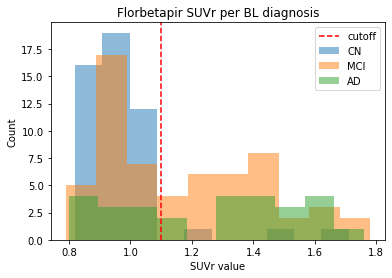

In [14]:
plt.title('Florbetapir SUVr per BL diagnosis')
plt.hist(fbp_CN.values.ravel(),alpha=0.5)
plt.hist(fbp_MCI.values.ravel(),alpha=0.5)
plt.hist(fbp_AD.values.ravel(),alpha=0.5)
plt.axvline(x=1.10, color='r', linestyle='--')
plt.legend(['cutoff','CN','MCI','AD'])
plt.xlabel('SUVr value')
plt.ylabel('Count')
plt.show()

## 4. Save data to be used by brainpainter

[Brain painter](https://brainpainter.csail.mit.edu/) requires a very specific ordering and format for the coloring.

In [13]:
# create dataframes with delta tau
dtau_CN = CN_longitudinal['tau']['visit_3'] - CN_longitudinal['tau']['visit_1']
dtau_MCI = MCI_longitudinal['tau']['visit_3'] - MCI_longitudinal['tau']['visit_1']
dtau_AD = AD_longitudinal['tau']['visit_3'] - AD_longitudinal['tau']['visit_1']

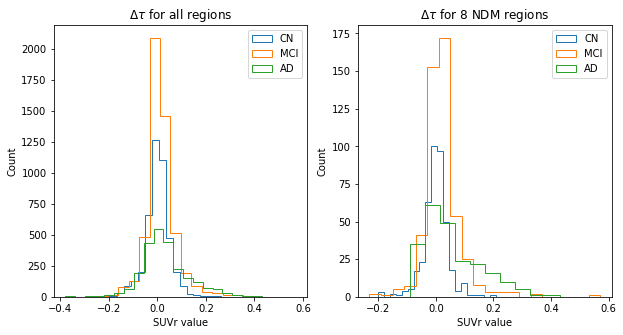

In [16]:
# check if dataframes make sense
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.title(r'$\Delta\tau$'+' for all regions')
plt.hist(dtau_CN.values.ravel(), histtype='step', bins=20)
plt.hist(dtau_MCI.values.ravel(), histtype='step', bins=20)
plt.hist(dtau_AD.values.ravel(), histtype='step', bins=20)
plt.legend(['CN','MCI','AD'])
plt.xlabel('SUVr value')
plt.ylabel('Count')

plt.subplot(122)
plt.title(r'$\Delta\tau$'+' for 8 NDM regions')
plt.hist(dtau_CN[NDM_predicted_regions].values.ravel(), histtype='step', bins=20)
plt.hist(dtau_MCI[NDM_predicted_regions].values.ravel(), histtype='step', bins=20)
plt.hist(dtau_AD[NDM_predicted_regions].values.ravel(), histtype='step', bins=10)
plt.legend(['CN','MCI','AD'])
plt.xlabel('SUVr value')
plt.ylabel('Count')
plt.show()

### Calculate mean df per diagnosis group

In [14]:
# create DFs with mean values
mean_dtau_df = pd.DataFrame(dtau_CN.mean(axis=0))
mean_dtau_df = mean_dtau_df.rename({0:'CN'}, axis='columns')
mean_dtau_df['MCI'] = pd.DataFrame(dtau_MCI.mean(axis=0))
mean_dtau_df['AD'] = pd.DataFrame(dtau_AD.mean(axis=0))

mean_tau_df = pd.DataFrame(CN_longitudinal['tau']['visit_1'].mean(axis=0))
mean_tau_df = mean_dtau_df.rename({0:'CN'}, axis='columns')
mean_tau_df['MCI'] = pd.DataFrame(pd.DataFrame(MCI_longitudinal['tau']['visit_1'].mean(axis=0)))
mean_tau_df['AD'] = pd.DataFrame(pd.DataFrame(AD_longitudinal['tau']['visit_1'].mean(axis=0)))

mean_atrophy_df = pd.DataFrame(CN_longitudinal['atrophy']['visit_1'].mean(axis=0))
mean_atrophy_df = mean_atrophy_df.rename({0:'CN'}, axis='columns')
mean_atrophy_df['MCI'] = pd.DataFrame(pd.DataFrame(MCI_longitudinal['atrophy']['visit_1'].mean(axis=0)))
mean_atrophy_df['AD'] = pd.DataFrame(pd.DataFrame(AD_longitudinal['atrophy']['visit_1'].mean(axis=0)))

# create normalized dfs with regions as in brain-paint ordering
brain_painter_dtau = atlas_utils.return_brain_paint_df(df=mean_dtau_df.clip(0).T, DK_convention='Other Name', MAX=4)
brain_painter_tau = atlas_utils.return_brain_paint_df(df=mean_tau_df.clip(0.8).T, DK_convention='Other Name', MAX=4)
brain_painter_atrophy = atlas_utils.return_brain_paint_df(df=mean_atrophy_df.T, DK_convention='Other Name', MAX=4)

# save csv files
brain_painter_dtau.to_csv("../data/brain_painter_data/mean_brain_painter_dtau.csv")
brain_painter_tau.to_csv("../data/brain_painter_data/mean_brain_painter_tau.csv")
brain_painter_atrophy.to_csv("../data/brain_painter_data/mean_brain_painter_atrophy.csv")

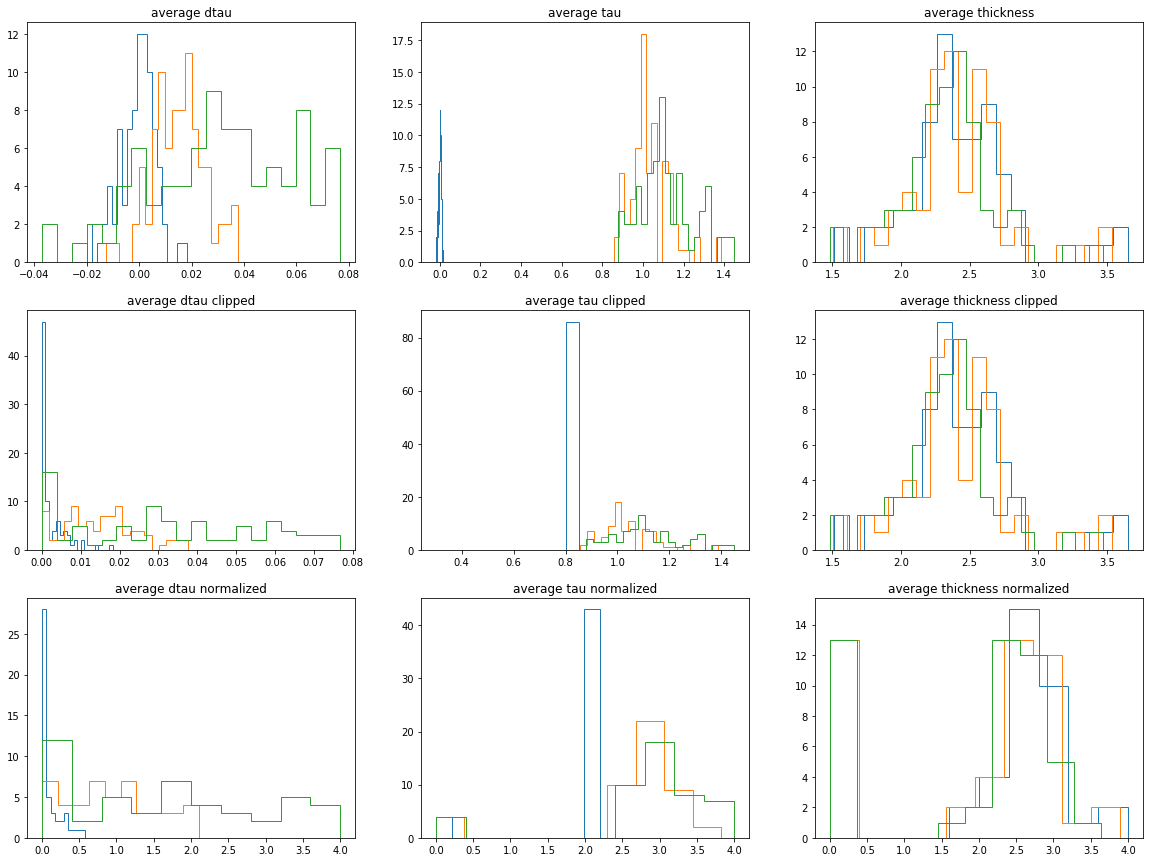

In [18]:
plt.figure(figsize=(20,15))
plt.subplot(331)
plt.title('average dtau')
plt.hist(mean_dtau_df['CN'], histtype='step', bins=20)
plt.hist(mean_dtau_df['MCI'], histtype='step', bins=20)
plt.hist(mean_dtau_df['AD'], histtype='step', bins=20)

plt.subplot(332)
plt.title('average tau')
plt.hist(mean_tau_df['CN'], histtype='step', bins=20)
plt.hist(mean_tau_df['MCI'], histtype='step', bins=20)
plt.hist(mean_tau_df['AD'], histtype='step', bins=20)

plt.subplot(333)
plt.title('average thickness')
plt.hist(mean_atrophy_df['CN'], histtype='step', bins=20)
plt.hist(mean_atrophy_df['MCI'], histtype='step', bins=20)
plt.hist(mean_atrophy_df['AD'], histtype='step', bins=20)

plt.subplot(334)
plt.title('average dtau clipped')
plt.hist(mean_dtau_df['CN'].clip(0), histtype='step', bins=20)
plt.hist(mean_dtau_df['MCI'].clip(0), histtype='step', bins=20)
plt.hist(mean_dtau_df['AD'].clip(0), histtype='step', bins=20)

plt.subplot(335)
plt.title('average tau clipped')
plt.hist(mean_tau_df['CN'].clip(0.8), histtype='step', bins=20)
plt.hist(mean_tau_df['MCI'].clip(0.8), histtype='step', bins=20)
plt.hist(mean_tau_df['AD'].clip(0.8), histtype='step', bins=20)

plt.subplot(336)
plt.title('average thickness clipped')
plt.hist(mean_atrophy_df['CN'], histtype='step', bins=20)
plt.hist(mean_atrophy_df['MCI'], histtype='step', bins=20)
plt.hist(mean_atrophy_df['AD'], histtype='step', bins=20)

plt.subplot(337)
plt.title('average dtau normalized')
plt.hist(brain_painter_dtau.loc['CN'], histtype='step', bins=10)
plt.hist(brain_painter_dtau.loc['MCI'], histtype='step', bins=10)
plt.hist(brain_painter_dtau.loc['AD'], histtype='step', bins=10)

plt.subplot(338)
plt.title('average tau normalized')
plt.hist(brain_painter_tau.loc['CN'], histtype='step', bins=10)
plt.hist(brain_painter_tau.loc['MCI'], histtype='step', bins=10)
plt.hist(brain_painter_tau.loc['AD'], histtype='step', bins=10)

plt.subplot(339)
plt.title('average thickness normalized')
plt.hist(brain_painter_atrophy.loc['CN'], histtype='step', bins=10)
plt.hist(brain_painter_atrophy.loc['MCI'], histtype='step', bins=10)
plt.hist(brain_painter_atrophy.loc['AD'], histtype='step', bins=10)
plt.show()

### Compare regions of highest delta_tau change with NDM regions

In [19]:
brain_painter_dtau.loc['AD'].sort_values()[-12:]

lateraloccipital        2.60
rostralmiddlefrontal    2.82
bankssts                2.98
superiorparietal        3.32
supramarginal           3.36
inferiortemporal        3.44
superiorfrontal         3.46
parsopercularis         3.52
precuneus               3.62
inferiorparietal        3.78
middletemporal          3.86
caudalmiddlefrontal     4.00
Name: AD, dtype: float64

In [20]:
NDM_predicted_regions

['rh_superiortemporal',
 'lh_superiortemporal',
 'rh_lateraloccipital',
 'lh_lateraloccipital',
 'lh_precuneus',
 'lh_superiorfrontal',
 'rh_precuneus',
 'rh_superiorfrontal']

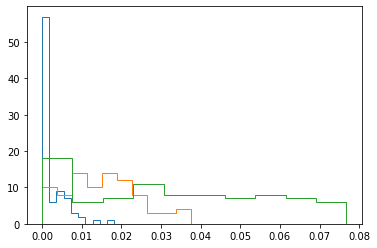

In [21]:
plt.hist(mean_dtau_df.clip(0)['CN'], histtype='step', bins=10)
plt.hist(mean_dtau_df.clip(0)['MCI'], histtype='step', bins=10)
plt.hist(mean_dtau_df.clip(0)['AD'], histtype='step', bins=10)
plt.show()

## 5. NDM-predicted regions

In [15]:
# Use Laplacian with high diagonal elements
L = atlas_utils.load_laplacian(n=0)

In [16]:
braak_regions = {str(stage):  list(DK[DK['Braak stage'] == stage].index) for stage in [1.0, 2.0, 3.0, 4.0, 5.0, 6.0]}
braak_regions_123 = braak_regions['1.0'] + braak_regions['2.0'] + braak_regions['3.0']
braak_regions_1234 = braak_regions['1.0'] + braak_regions['2.0'] + braak_regions['3.0'] + braak_regions['4.0']
braak_regions_12345 = braak_regions['1.0'] + braak_regions['2.0'] + braak_regions['3.0'] + braak_regions['4.0'] + braak_regions['5.0']

In [17]:
# Create a seed vector with 1s in the braak regions 1-4

seed_vector = pd.DataFrame(columns=L.columns)
seed_vector.loc['seed vector'] = 0.

# for region in braak_regions_1234:
#     seed_vector[region] = 1.0

for region in braak_regions['1.0']:
    seed_vector[region] = 1.0

for region in braak_regions['2.0']:
    seed_vector[region] = 1.0

for region in braak_regions['3.0']:
    seed_vector[region] = 1.0

for region in braak_regions['4.0']:
    seed_vector[region] = 1.0

In [20]:
LxTau = np.matmul(-np.array(L), np.array(seed_vector.T)).ravel()
LxTau = pd.DataFrame(LxTau, index=L.columns).T

LxTau_cortical = LxTau[list(DK[DK['Cortex']=='cortical'].index)]
sorted_LxTau_cortical = LxTau_cortical.sort_values(by=0, axis=1)

In [21]:
sorted_LxTau_cortical

,ctx-rh-insula,ctx-lh-insula,ctx-rh-lingual,ctx-lh-lingual,ctx-rh-middletemporal,ctx-lh-middletemporal,ctx-rh-fusiform,ctx-lh-fusiform,ctx-lh-posteriorcingulate,ctx-lh-rostralanteriorcingulate,...,ctx-lh-pericalcarine,ctx-rh-bankssts,ctx-rh-superiorfrontal,ctx-rh-precuneus,ctx-lh-superiorfrontal,ctx-lh-precuneus,ctx-lh-lateraloccipital,ctx-rh-lateraloccipital,ctx-lh-superiortemporal,ctx-rh-superiortemporal
0,-169.809657,-146.238164,-114.912449,-112.551677,-104.440209,-98.284502,-95.071303,-86.880497,-61.552571,-52.520322,...,31.794405,37.547631,47.420346,58.93632,59.357883,65.316879,75.753612,85.767123,102.273056,103.810419


In [56]:
DK.loc['ctx-lh-precentral']

Short Name                            lpreC 
x.mni                                    -44
y.mni                                    -12
z.mni                                     59
Hemisphere                              Left
Cortex                              cortical
Other Name                     lh_precentral
Other Name 2                    Precentral_L
Other Name 3                   precentral_lh
Other Name 4                   precentral_LV
Other Name 5                      precentral
functional_system    motor and somatosensory
Braak stage                                6
index                                     23
Name: ctx-lh-precentral, dtype: object

In [25]:
LxTau = np.matmul(-np.array(L), np.array(seed_vector.T)).ravel()
LxTau = pd.DataFrame(LxTau, index=L.columns).T

LxTau_cortical = LxTau[list(DK[DK['Cortex']=='cortical'].index)]
sorted_LxTau_cortical = LxTau_cortical.sort_values(by=0, axis=1)
resorted_LxTau_cortical = LxTau_cortical.sort_values(by=0, axis=1, ascending=False)

In [26]:
braak_4_NDM = atlas_utils.return_brain_paint_df(df=LxTau_cortical, DK_convention='ctx', MAX=4)

In [27]:
top_regions = resorted_LxTau_cortical.columns[:8]
top_regions_brain_painter = list(set(DK.loc[top_regions]['Other Name 5'].values))

top_braak_4_NDM = braak_4_NDM.copy()
top_braak_4_NDM *= 0.0
top_braak_4_NDM[top_regions_brain_painter] = 4.0

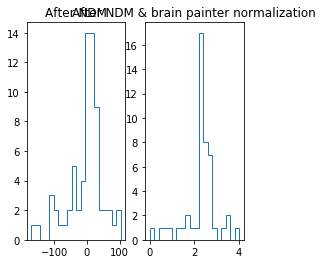

In [28]:
# plt.figure(figsize=(15,5))
# plt.subplot(1,3,1)
# plt.title('Original Braak 4 features')
# plt.hist(braak_4_brain_painter, histtype='step', bins=20)

plt.subplot(1,3,2)
plt.title('After NDM')
plt.hist(LxTau_cortical, histtype='step', bins=20)

plt.subplot(1,3,3)
plt.title('After NDM & brain painter normalization')
plt.hist(braak_4_NDM, histtype='step', bins=20)

plt.show()

#ps: brain painter adds 0 to subcorticals regions, only takes the left and re-normalizes

In [29]:
# Create 3 brain-painter-ready dataframes:
# 1. Braak 1-4 regions
# braak_4_brain_painter.to_csv("../data/brain_painter_data/braak_4_brain_painter.csv")

# 2. Braak 4 after NDM
braak_4_NDM.to_csv("../data/brain_painter_data/braak_4_NDM.csv")

# 3. Top 8 regions
top_braak_4_NDM.to_csv("../data/brain_painter_data/braak_4_NDM_top_regions.csv")

## Making histograms for Fig 3

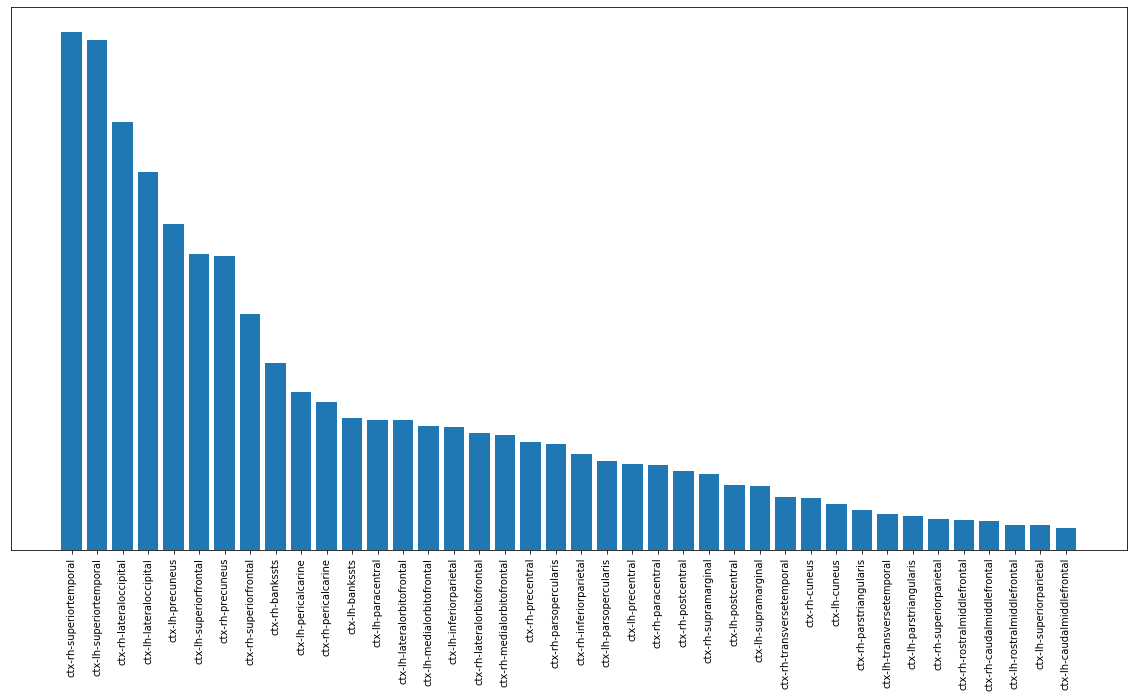

In [30]:
plt.figure(figsize=(20,10))
plt.bar(resorted_LxTau_cortical.columns[:40], resorted_LxTau_cortical.values.ravel()[:40])
plt.xticks(resorted_LxTau_cortical.columns[:40], resorted_LxTau_cortical.columns[:40], rotation='vertical')
plt.yticks([])
plt.show()

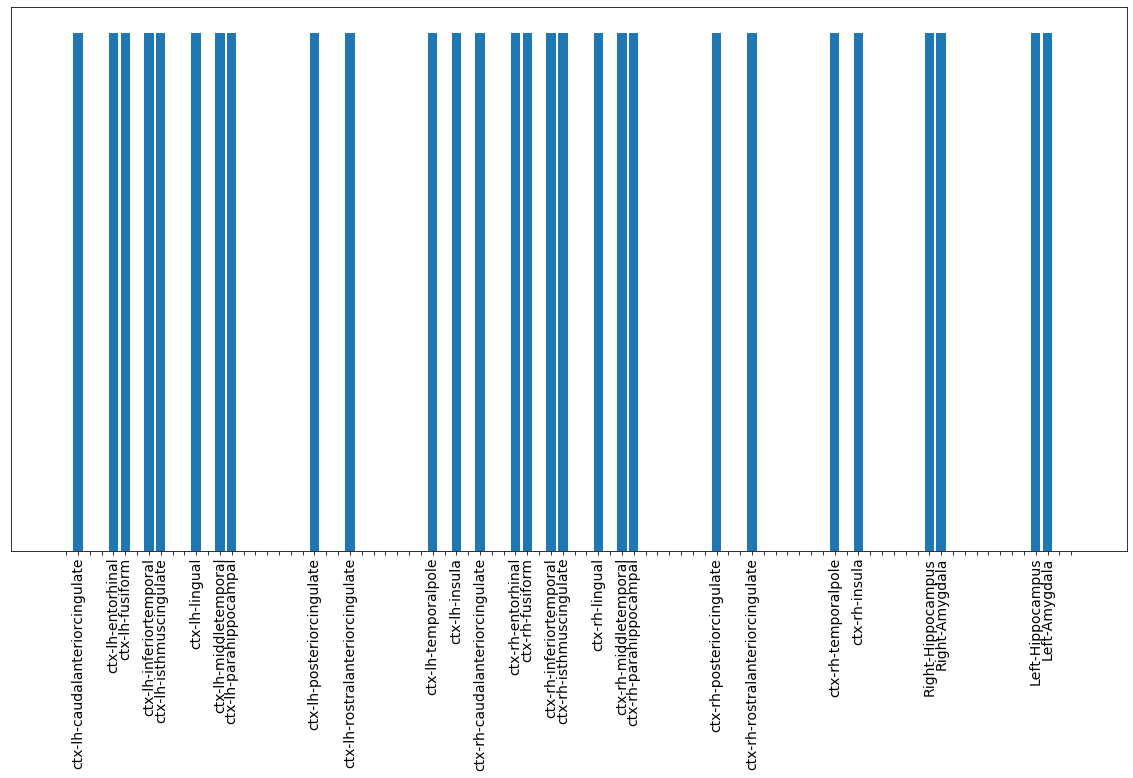

In [31]:
names_non_zero = []
for col in seed_vector.columns:
    if float(seed_vector[col]) > 0.0:
        names_non_zero.append(col)
    else:
        names_non_zero.append(" ")
        
plt.figure(figsize=(20,10))
plt.bar(seed_vector.columns[:86], seed_vector.values.ravel()[:86])
plt.xticks(seed_vector.columns[:86], names_non_zero, rotation='vertical', fontsize=14)
plt.yticks([])
plt.show()

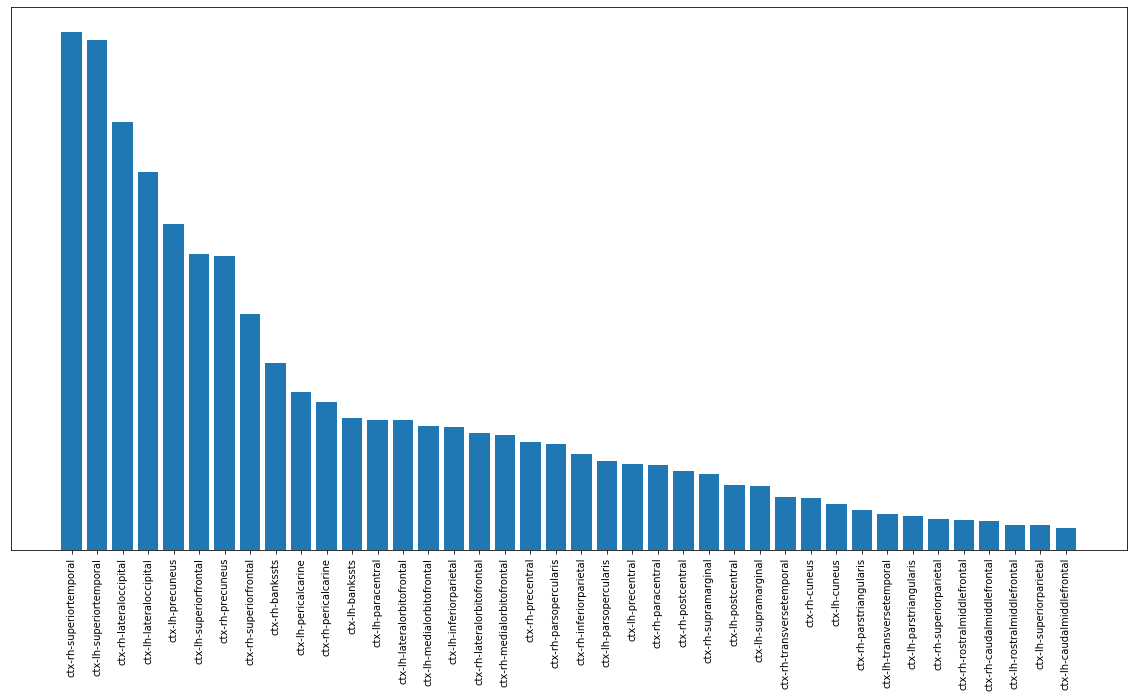

In [32]:
plt.figure(figsize=(20,10))
plt.bar(resorted_LxTau_cortical.columns[:40], resorted_LxTau_cortical.values.ravel()[:40])
plt.xticks(resorted_LxTau_cortical.columns[:40], resorted_LxTau_cortical.columns[:40], rotation='vertical')
plt.yticks([])
plt.show()

In [33]:
top_8 = resorted_LxTau_cortical.copy()
top_8 *= 0
top_8[resorted_LxTau_cortical.columns[:8]] = resorted_LxTau_cortical[resorted_LxTau_cortical.columns[:8]]

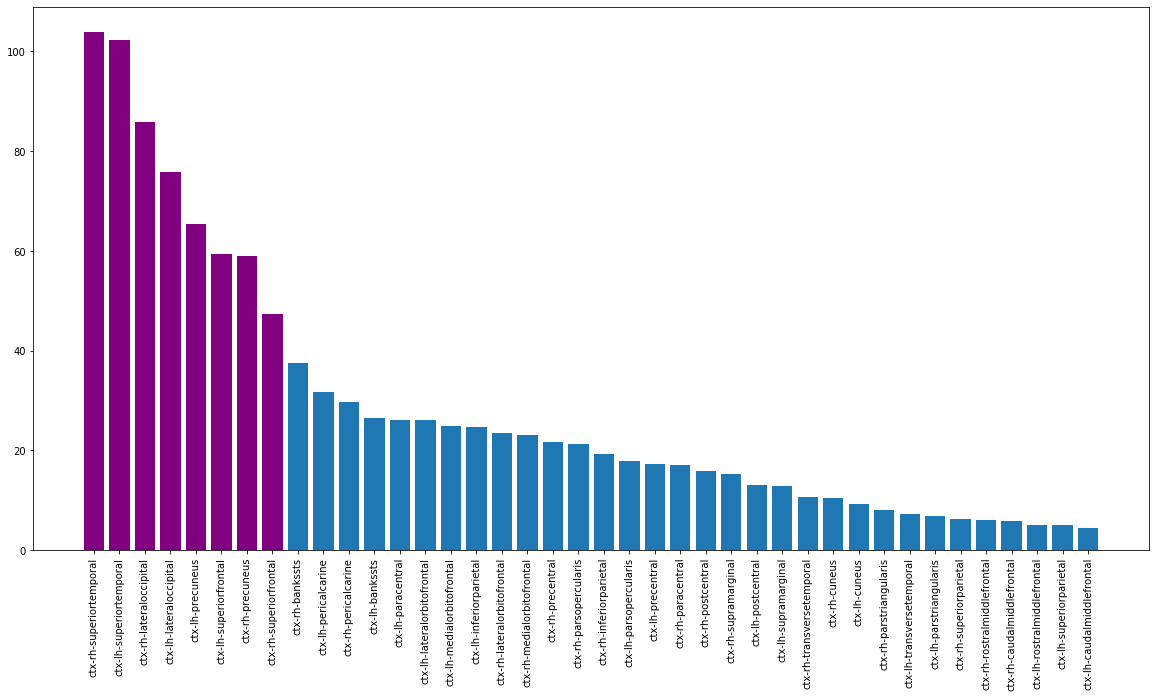

In [34]:
plt.figure(figsize=(20,10))
plt.bar(resorted_LxTau_cortical.columns[:40], resorted_LxTau_cortical.values.ravel()[:40])
plt.bar(top_8.columns[:40], top_8.values.ravel()[:40], color='purple')
plt.xticks(resorted_LxTau_cortical.columns[:40], resorted_LxTau_cortical.columns[:40], rotation='vertical')
# plt.yticks([])
plt.show()

In [35]:
NDM_predicted_regions

['rh_superiortemporal',
 'lh_superiortemporal',
 'rh_lateraloccipital',
 'lh_lateraloccipital',
 'lh_precuneus',
 'lh_superiorfrontal',
 'rh_precuneus',
 'rh_superiorfrontal']

In [36]:
resorted_LxTau_cortical.columns[:12]

Index(['ctx-rh-superiortemporal', 'ctx-lh-superiortemporal',
       'ctx-rh-lateraloccipital', 'ctx-lh-lateraloccipital',
       'ctx-lh-precuneus', 'ctx-lh-superiorfrontal', 'ctx-rh-precuneus',
       'ctx-rh-superiorfrontal', 'ctx-rh-bankssts', 'ctx-lh-pericalcarine',
       'ctx-rh-pericalcarine', 'ctx-lh-bankssts'],
      dtype='object')

## Clinical

### AD

In [54]:
#AD subjects w/ 3 time points
AD_subjs = diagnosis[diagnosis['Clinical Diagnosis']=='AD']
AD_subjs = AD_subjs.loc[AD_longitudinal['tau']['visit_3'].index]

In [56]:
AD_age_mean = AD_subjs['Age'].mean()
AD_age_std  = AD_subjs['Age'].std()
AD_age_min  = AD_subjs['Age'].min()
AD_age_max  = AD_subjs['Age'].max()

print('AD_age_mean :', AD_age_mean )
print('AD_age_std  :', AD_age_std  )
print('AD_age_min  :', AD_age_min  )
print('AD_age_max  :', AD_age_max  )

AD_age_mean : 75.75
AD_age_std  : 8.090346327797327
AD_age_min  : 59
AD_age_max  : 95


In [71]:
AD_num_female = len(AD_subjs[AD_subjs['Sex']=='Female'])

print('AD_num_female: ', AD_num_female)
print('AD_num_female %: ', AD_num_female / len(AD_subjs))

AD_num_female:  16
AD_num_female %:  0.5714285714285714


In [79]:
AD_APOE4 = AD_subjs[AD_subjs['APOE4 ']=='E4/E4']
AD_num_APOE4 = len(AD_APOE4)

print('AD_num_APOE4: ', AD_num_APOE4)
print('AD_num_APOE4 %: ', AD_num_APOE4 / len(AD_subjs))

AD_num_APOE4:  4
AD_num_APOE4 %:  0.14285714285714285


In [89]:
AD_FBP_pos = AD_subjs[AD_subjs['FBP Visual Read']=='Positive']
AD_FBP_neg = AD_subjs[AD_subjs['FBP Visual Read']=='Negative']

print('AD_FBP_pos: ', len(AD_FBP_pos))
print('AD_FBP_neg: ', len(AD_FBP_neg))
print('AD_FBP_both: ', len(AD_FBP_neg) + len(AD_FBP_pos))


AD_FBP_pos:  18
AD_FBP_neg:  10
AD_FBP_both:  28


### MCI

In [80]:
#MCI subjects w/ 3 time points
MCI_subjs = diagnosis[diagnosis['Clinical Diagnosis']=='MCI']
MCI_subjs = MCI_subjs.loc[MCI_longitudinal['tau']['visit_3'].index]

In [81]:
MCI_age_mean = MCI_subjs['Age'].mean()
MCI_age_std  = MCI_subjs['Age'].std()
MCI_age_min  = MCI_subjs['Age'].min()
MCI_age_max  = MCI_subjs['Age'].max()

print('MCI_age_mean :', MCI_age_mean )
print('MCI_age_std  :', MCI_age_std  )
print('MCI_age_min  :', MCI_age_min  )
print('MCI_age_max  :', MCI_age_max  )

MCI_age_mean : 71.68333333333334
MCI_age_std  : 9.3146352251997
MCI_age_min  : 50
MCI_age_max  : 92


In [82]:
MCI_num_female = len(MCI_subjs[MCI_subjs['Sex']=='Female'])

print('MCI_num_female: ', MCI_num_female)
print('MCI_num_female %: ', MCI_num_female / len(MCI_subjs))

MCI_num_female:  28
MCI_num_female %:  0.4666666666666667


In [83]:
MCI_APOE4 = MCI_subjs[MCI_subjs['APOE4 ']=='E4/E4']
MCI_num_APOE4 = len(MCI_APOE4)

print('MCI_num_APOE4: ', MCI_num_APOE4)
print('MCI_num_APOE4 %: ', MCI_num_APOE4 / len(MCI_subjs))

MCI_num_APOE4:  6
MCI_num_APOE4 %:  0.1


In [90]:
MCI_FBP_pos = MCI_subjs[MCI_subjs['FBP Visual Read']=='Positive']
MCI_FBP_neg = MCI_subjs[MCI_subjs['FBP Visual Read']=='Negative']

print('MCI_FBP_pos: ', len(MCI_FBP_pos))
print('MCI_FBP_neg: ', len(MCI_FBP_neg))
print('MCI_FBP_both: ', len(MCI_FBP_neg) + len(MCI_FBP_pos))


MCI_FBP_pos:  28
MCI_FBP_neg:  32
MCI_FBP_both:  60
